# **BitePulse AI - Modeling: Pose TCN vs Hyperband TCN**

* **Name/Group:** Aktham Almomani / Group 13

## **Introduction**

In this notebook we:

1. Build windowed pose data for BitePulse (EatSense).
2. Train a **baseline PyTorch Temporal ConvNet (PoseTCNPro)** on pose sequences.
3. Train a **Keras TCN with Hyperband** on the same windows.
4. Evaluate both models with the **same metrics and plots**:
   - Window-level confusion matrix, ROC, PR.
   - Event-level precision/recall based on window outputs.

The goal is to see how much Hyperband improves over the baseline TCN and to
understand where each model succeeds or fails.

## **Data**

Our input will be the artifacts we finalized at proveious Feature pipeline notebook:

* Manifest w/ splits: labels_v1/manifest_with_split.parquet (keys, paths, split).
* Per-frame labels: labels_v1/frames_idx.parquet (key, split, frame, time_sec, label).
* Event segments: labels_v1/segs_idx.parquet (key, split, start_sec, end_sec, label).
These are the artifacts we finalized at the end of Week 2; the notebook will load them directly.



## **Imports and basic setup**

In [ ]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Core
import os, sys, math, json, time, random, logging, re
from pathlib import Path
from typing import Dict, Any, Optional

# Data / arrays
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Keras / Hyperband
import tensorflow as tf
import keras_tuner as kt

# Metrics
from sklearn.metrics import (
    precision_recall_curve, roc_curve, roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, confusion_matrix, auc,
    classification_report
)

from tqdm.auto import tqdm
from contextlib import nullcontext


## **Paths setup**

Here's let's define our exact folders on Drive.

In [ ]:
ROOT       = Path("/content/drive/MyDrive/eatsense")
DATA_DIR   = ROOT
LABELS_DIR = ROOT / "labels_v1"
POSE_DIR   = ROOT / "true2d_parquet"
FRAMES_DIR = ROOT / "frames"
CKPT_DIR   = ROOT / "checkpoints"
LOG_DIR    = ROOT / "logs"

for d in [CKPT_DIR, LOG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

CONFIG: Dict[str, Any] = {
    "seed": 1981,
    "num_workers": 2,
    "pin_memory": True,
    "persistent_workers": True,
    # windowing
    "win_sec": 2.0,
    "stride_sec": 0.5,
    # training
    "epochs": 12,
    "batch_size": 32,
    "lr": 3e-4,
    "weight_decay": 1e-5,
    "pos_class_weight": 2.0,      # BCE pos_weight for TCN
    "amp": True,
    "amp_dtype": "bf16",
    # eval default threshold
    "pred_thresh": 0.5,
}


In [ ]:
# Quick sanity checks:
need = [LABELS_DIR / "manifest_with_split.parquet",
        LABELS_DIR / "frames_idx.parquet",
        LABELS_DIR / "segs_idx.parquet",
        POSE_DIR]
missing = [str(p) for p in need if not Path(p).exists()]
if missing:
    print("Missing expected paths/files:\n - " + "\n - ".join(missing))
else:
    print("Paths OK")

print(f"ROOT={ROOT}\nLABELS_DIR={LABELS_DIR}\nPOSE_DIR={POSE_DIR}\nFRAMES_DIR={FRAMES_DIR}\nCKPT_DIR={CKPT_DIR}\nLOG_DIR={LOG_DIR}")

Paths OK
ROOT=/content/drive/MyDrive/eatsense
LABELS_DIR=/content/drive/MyDrive/eatsense/labels_v1
POSE_DIR=/content/drive/MyDrive/eatsense/true2d_parquet
FRAMES_DIR=/content/drive/MyDrive/eatsense/frames
CKPT_DIR=/content/drive/MyDrive/eatsense/checkpoints
LOG_DIR=/content/drive/MyDrive/eatsense/logs


## **Helpers**

In [ ]:
def set_seed(seed: int = 1981):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE.type} | Torch: {torch.__version__}")


Device: cuda | Torch: 2.9.0+cu126


In [ ]:
def get_logger(name="bitepulse", level=logging.INFO,
               log_file: Optional[Path] = LOG_DIR / "run_tcn.log"):
    logger = logging.getLogger(name)
    if logger.handlers:
        return logger
    logger.setLevel(level)
    fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")
    sh = logging.StreamHandler(stream=sys.stdout)
    sh.setFormatter(fmt)
    logger.addHandler(sh)
    if log_file:
        fh = logging.FileHandler(log_file)
        fh.setFormatter(fmt)
        logger.addHandler(fh)
    return logger

LOGGER = get_logger()

class SmoothedValue:
    def __init__(self):
        self.n, self.total = 0, 0.0
    def update(self, val, cnt=1):
        self.total += float(val) * cnt
        self.n += cnt
    @property
    def avg(self):
        return self.total / max(self.n, 1)

def make_amp_ctx():
    if not CONFIG["amp"] or DEVICE.type != "cuda":
        return nullcontext
    if CONFIG.get("amp_dtype", "bf16") == "bf16":
        return lambda: torch.amp.autocast("cuda", dtype=torch.bfloat16)
    else:
        return lambda: torch.amp.autocast("cuda", dtype=torch.float16)

AMP_CTX = make_amp_ctx()
SCALER  = (torch.amp.GradScaler('cuda')
           if (CONFIG["amp"] and CONFIG.get("amp_dtype", "bf16") == "fp16")
           else None)


In [ ]:
MANIFEST_PATH   = LABELS_DIR / "manifest_with_split.parquet"
FRAMES_IDX_PATH = LABELS_DIR / "frames_idx.parquet"
SEGS_IDX_PATH   = LABELS_DIR / "segs_idx.parquet"

for p in [MANIFEST_PATH, FRAMES_IDX_PATH, SEGS_IDX_PATH]:
    assert p.exists(), f"Missing: {p}"

manifest  = pd.read_parquet(MANIFEST_PATH)
frames_ix = pd.read_parquet(FRAMES_IDX_PATH)
segs_ix   = pd.read_parquet(SEGS_IDX_PATH)

_time_col = "time_sec" if "time_sec" in frames_ix.columns else None
if _time_col is None and {"frame","fps"}.issubset(frames_ix.columns):
    frames_ix = frames_ix.copy()
    frames_ix["time_sec"] = frames_ix["frame"] / frames_ix["fps"]
    _time_col = "time_sec"
assert _time_col is not None, "frames_idx must have time_sec or (frame,fps)."


In [ ]:
INTAKE_LABELS = {"Eat it"}
WINDOW_POS_OVERLAP = 0.25

WIN_SEC  = float(CONFIG["win_sec"])
STRIDE_S = float(CONFIG["stride_sec"])

def _dur(key: str) -> float:
    f = frames_ix[frames_ix["key"] == key]
    return float(f[_time_col].max()) if len(f) else 0.0

def _iou(a0, a1, b0, b1) -> float:
    inter = max(0.0, min(a1, b1) - max(a0, b0))
    if inter <= 0:
        return 0.0
    union = (a1 - a0) + (b1 - b0) - inter + 1e-9
    return inter / union

# keep only positive intake segments:
if "label" in segs_ix.columns:
    if segs_ix["label"].dtype.kind in "iu":
        segs_pos = segs_ix[segs_ix["label"].astype(int) == 1].copy()
    else:
        segs_pos = segs_ix[segs_ix["label"].astype(str).isin(list(INTAKE_LABELS))].copy()
else:
    segs_pos = segs_ix.copy()

def _label_window(key: str, w0: float, w1: float) -> int:
    s = segs_pos[segs_pos["key"] == key]
    if s.empty:
        return 0
    ious = s.apply(
        lambda r: _iou(w0, w1, float(r["start_sec"]), float(r["end_sec"])),
        axis=1
    ).to_numpy()
    return int((ious >= WINDOW_POS_OVERLAP).any())

rows = []
for key, g in manifest.groupby("key"):
    split = g["split"].iloc[0] if "split" in g.columns else "train"
    dur = _dur(key)
    if dur <= 0:
        continue
    t = 0.0
    while t + WIN_SEC <= dur + 1e-6:
        w0, w1 = t, t + WIN_SEC
        rows.append((key, split, w0, w1, _label_window(key, w0, w1)))
        t += STRIDE_S

windows_df = pd.DataFrame(
    rows, columns=["key","split","start_sec","end_sec","label"]
).astype({"key":"string","split":"string","start_sec":"float32","end_sec":"float32","label":"int8"})

out_path = LOG_DIR / "windows_idx.parquet"
windows_df.to_parquet(out_path)
cnt = windows_df.value_counts("split").to_dict()
pos_rate = float((windows_df["label"]==1).mean())
LOGGER.info(f"windows_idx saved: {out_path} | rows={len(windows_df)} | by split={cnt} | pos_rate={pos_rate:.3f}")


2025-11-26 19:51:15,470 | INFO | windows_idx saved: /content/drive/MyDrive/eatsense/logs/windows_idx.parquet | rows=98582 | by split={'train': 62568, 'val': 21184, 'test': 14830} | pos_rate=0.006


INFO:bitepulse:windows_idx saved: /content/drive/MyDrive/eatsense/logs/windows_idx.parquet | rows=98582 | by split={'train': 62568, 'val': 21184, 'test': 14830} | pos_rate=0.006


## **Baseline PyTorch Temporal ConvNet (PoseTCNPro)**

In [ ]:
class PoseWindowDataset(Dataset):
    """
    Each item: (T, F) pose window tensor, label in {0,1}.
    Expects POSE_DIR / '{key}.parquet' with 'time_sec' and numeric joint cols.
    """
    def __init__(self, windows: pd.DataFrame, fps: float = 30.0,
                 cols_regex: str = r"^(x_|y_|z_|j\d+)"):
        self.df = windows.reset_index(drop=True)
        self.fps = float(fps)
        self.T   = max(1, int(round(CONFIG["win_sec"] * self.fps)))
        self._re = re.compile(cols_regex)
        self._cache = {}

    def _pose_df(self, key: str) -> pd.DataFrame:
        if key in self._cache:
            return self._cache[key]
        p = POSE_DIR / f"{key}.parquet"
        df = pd.read_parquet(p)
        assert "time_sec" in df.columns, "pose parquet must include 'time_sec'."
        cols = [c for c in df.columns
                if c!="time_sec" and pd.api.types.is_numeric_dtype(df[c])
                and self._re.search(str(c))]
        if not cols:
            cols = [c for c in df.columns
                    if c!="time_sec" and pd.api.types.is_numeric_dtype(df[c])]
        df = df[["time_sec"] + cols]
        self._cache[key] = df
        return df

    def _slice(self, key: str, w0: float, w1: float) -> torch.Tensor:
        df = self._pose_df(key)
        m  = (df["time_sec"] >= w0) & (df["time_sec"] < w1)
        clip = df.loc[m].drop(columns=["time_sec"]).to_numpy(dtype=np.float32)

        if clip.size == 0:
            F_ = len(df.columns) - 1
            arr = np.zeros((self.T, F_), dtype=np.float32)
        else:
            clip = np.nan_to_num(clip, nan=0.0, posinf=0.0, neginf=0.0)
            idx = np.linspace(0, max(len(clip)-1, 0), num=self.T).round().astype(int)
            arr = clip[idx]

        if arr.size:
            mu = arr.mean(0, keepdims=True)
            sd = arr.std(0, keepdims=True)
            sd = np.where(sd < 1e-6, 1e-6, sd)
            arr = (arr - mu) / sd

        arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
        return torch.from_numpy(arr)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        x = self._slice(r["key"], float(r["start_sec"]), float(r["end_sec"]))
        y = torch.tensor(int(r["label"]), dtype=torch.long)
        return x, y

def collate_pose(batch):
    xs, ys = zip(*batch)
    return torch.stack(xs, dim=0), torch.tensor(ys, dtype=torch.long)


In [ ]:
def make_pose_loader(windows_df, split, fps=15.0, balance=True):
    df_split = windows_df[windows_df["split"] == split].reset_index(drop=True)
    ds = PoseWindowDataset(df_split, fps=fps)

    if balance and split == "train":
        labels = ds.df["label"].astype(int).values
        counts = np.bincount(labels, minlength=2).astype(np.float32)
        weights = 1.0 / (counts[labels] + 1e-9)
        sampler = WeightedRandomSampler(weights.tolist(),
                                        num_samples=len(weights),
                                        replacement=True)
        shuffle = False
    else:
        sampler = None
        shuffle = (split == "train")

    loader = DataLoader(
        ds,
        batch_size=CONFIG["batch_size"],
        shuffle=shuffle if sampler is None else False,
        sampler=sampler,
        collate_fn=collate_pose,
        num_workers=CONFIG["num_workers"],
        pin_memory=CONFIG["pin_memory"],
        persistent_workers=CONFIG["persistent_workers"] if CONFIG["num_workers"] > 0 else False,
        drop_last=False,
    )
    return loader, ds

train_pose_loader, train_pose_ds = make_pose_loader(windows_df, "train", fps=15.0, balance=True)
val_pose_loader,   val_pose_ds   = make_pose_loader(windows_df, "val",   fps=15.0, balance=False)

sample_x, _ = next(iter(train_pose_loader))
in_feats = sample_x.shape[-1]
print("Pose window shape:", sample_x.shape, " | in_feats:", in_feats)


Pose window shape: torch.Size([32, 30, 19])  | in_feats: 19


In [ ]:
class Chomp1d(nn.Module):
    def __init__(self, chomp):
        super().__init__()
        self.chomp = chomp
    def forward(self, x):
        return x[..., :-self.chomp] if self.chomp > 0 else x

class SE1D(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(ch, ch // r, 1), nn.GELU(),
            nn.Conv1d(ch // r, ch, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)

class DSConv1D(nn.Module):
    """Depthwise-separable conv + LayerNorm + GELU."""
    def __init__(self, in_ch, out_ch, k=5, d=1, causal=True, p_drop=0.2):
        super().__init__()
        pad = (k - 1) * d if causal else ((k - 1) * d) // 2
        self.depth = nn.Conv1d(in_ch, in_ch, k, dilation=d,
                               padding=pad, groups=in_ch, bias=False)
        self.chomp = Chomp1d(pad) if causal else nn.Identity()
        self.point = nn.Conv1d(in_ch, out_ch, 1, bias=False)
        self.norm  = nn.LayerNorm(out_ch)
        self.drop  = nn.Dropout(p_drop)

    def forward(self, x):              # (B, C, T)
        y = self.depth(x)
        y = self.chomp(y)
        y = self.point(y)              # (B, Cout, T)
        y = self.norm(y.transpose(1,2)).transpose(1,2)
        y = F.gelu(y)
        return self.drop(y)

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=5, d=1,
                 causal=True, p_drop=0.2, use_se=True):
        super().__init__()
        self.conv1 = DSConv1D(in_ch,  out_ch, k=k, d=d,
                              causal=causal, p_drop=p_drop)
        self.conv2 = DSConv1D(out_ch, out_ch, k=k, d=d,
                              causal=causal, p_drop=p_drop)
        self.se    = SE1D(out_ch) if use_se else nn.Identity()
        self.res   = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.drop  = nn.Dropout(p_drop)

    def forward(self, x):
        y = self.conv2(self.conv1(x))
        y = self.se(y)
        y = y + self.res(x)
        return F.gelu(self.drop(y))

class AttnPool1D(nn.Module):
    """Additive attention pooling over time."""
    def __init__(self, ch, hidden=128):
        super().__init__()
        self.score = nn.Sequential(
            nn.Conv1d(ch, hidden, 1),
            nn.Tanh(),
            nn.Conv1d(hidden, 1, 1)
        )
    def forward(self, x):              # (B, C, T)
        w = torch.softmax(self.score(x), dim=-1)  # (B,1,T)
        return torch.sum(x * w, dim=-1)           # (B,C)

class PoseTCNPro(nn.Module):
    """Input: (B, T, F) -> logits (B,)"""
    def __init__(self, in_feats, base_ch=128, k=5,
                 dilations=(1,2,4,8,16), causal=True,
                 p_drop=0.2, use_se=True):
        super().__init__()
        self.in_proj = nn.Conv1d(in_feats, base_ch, 1)
        blocks, ch = [], base_ch
        for d in dilations:
            blocks.append(
                TemporalBlock(ch, ch, k=k, d=d,
                              causal=causal, p_drop=p_drop, use_se=use_se)
            )
        self.tcn  = nn.Sequential(*blocks)
        self.pool = AttnPool1D(ch, hidden=ch//2)
        self.head = nn.Sequential(
            nn.LayerNorm(ch),
            nn.Linear(ch, ch//2),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(ch//2, 1),
        )

    def forward(self, x):              # (B, T, F)
        x = x.transpose(1,2)           # (B, F, T)
        x = self.in_proj(x)
        x = self.tcn(x)                # (B, C, T)
        x = self.pool(x)               # (B, C)
        return self.head(x).squeeze(-1)


In [ ]:
def bin_metrics_from_logits_np(logits: np.ndarray,
                               targets: np.ndarray,
                               thr: float = 0.5) -> Dict[str, float]:
    probs = 1.0 / (1.0 + np.exp(-logits))
    preds = (probs >= thr).astype(int)
    y     = targets.astype(int)

    tp = int(((preds==1) & (y==1)).sum())
    fp = int(((preds==1) & (y==0)).sum())
    fn = int(((preds==0) & (y==1)).sum())
    tn = int(((preds==0) & (y==0)).sum())

    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1,
            "tp": tp, "fp": fp, "fn": fn, "tn": tn}

def best_f1_threshold_with_floor(
    logits: np.ndarray,
    targets: np.ndarray,
    prec_floor: float = 0.10,
    rec_floor: float  = 0.10,
):
    """Scan PR curve, pick threshold with max F1 under precision/recall floors."""
    y_true = targets.astype(int)
    probs  = 1.0 / (1.0 + np.exp(-logits.astype(np.float64)))
    P, R, T = precision_recall_curve(y_true, probs)

    best_f1, best_thr = 0.0, 0.5
    best_tuple = (0.0, 0.0, 0, 0, 0)  # (prec, rec, tp, fp, fn)

    for p, r, t in zip(P[:-1], R[:-1], T):
        if (p < prec_floor) or (r < rec_floor):
            continue
        f1 = 2 * p * r / (p + r + 1e-12)
        if f1 > best_f1:
            thr = float(t)
            preds = (probs >= thr).astype(int)
            tp = int(((preds==1) & (y_true==1)).sum())
            fp = int(((preds==1) & (y_true==0)).sum())
            fn = int(((preds==0) & (y_true==1)).sum())
            best_f1, best_thr = f1, thr
            best_tuple = (p, r, tp, fp, fn)

    return best_f1, best_thr, best_tuple


In [ ]:
def run_one_epoch(model, loader, optimizer=None):
    """
    One epoch over pose DataLoader.
    Returns: avg_loss, metrics_at_thr_0_5, logits_np, targets_np
    """
    train_mode = optimizer is not None
    model.train(train_mode)

    pos_w = torch.tensor(
        [CONFIG.get("pos_class_weight", 1.0)],
        device=DEVICE, dtype=torch.float32
    )
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_w)

    total_loss, n_seen = 0.0, 0
    all_logits, all_targets = [], []

    for x, y in tqdm(loader, desc="batches", leave=False):
        x = x.to(DEVICE, non_blocking=True).float()   # (B, T, F)
        y = y.to(DEVICE, non_blocking=True).float()   # (B,)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        logits = model(x)                             # (B,)
        loss   = criterion(logits, y)

        if train_mode:
            loss.backward()
            optimizer.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        n_seen += bs

        all_logits.append(logits.detach().cpu())
        all_targets.append(y.detach().cpu())

    logits_np  = torch.cat(all_logits, dim=0).numpy()
    targets_np = torch.cat(all_targets, dim=0).numpy().astype(int)
    m          = bin_metrics_from_logits_np(logits_np, targets_np, thr=0.5)

    return total_loss / max(1, n_seen), m, logits_np, targets_np


In [ ]:
def pick_best_threshold(logits_np, targets_np,
                        prec_floor=0.10, rec_floor=0.10):
    f1_star, thr_star, (prec, rec, tp, fp, fn) = best_f1_threshold_with_floor(
        logits_np, targets_np,
        prec_floor=prec_floor,
        rec_floor=rec_floor,
    )

    m = bin_metrics_from_logits_np(logits_np, targets_np, thr_star)
    return dict(
        thr=float(thr_star),
        f1=float(f1_star),
        acc=m["acc"],
        prec=m["prec"],
        rec=m["rec"],
        tp=m["tp"],
        fp=m["fp"],
        fn=m["fn"],
        tn=m["tn"],
    )


### **Baseline TCN Model Training**

In [ ]:
def train_tcn(train_loader, val_loader, in_feats: int):
    model = PoseTCNPro(
        in_feats=in_feats,
        base_ch=128,
        k=5,
        dilations=(1,2,4,8,16),
        causal=True,
        p_drop=0.2,
        use_se=True,
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG["lr"],
        weight_decay=CONFIG["weight_decay"],
    )
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=8e-4,
        steps_per_epoch=len(train_loader),
        epochs=CONFIG["epochs"],
    )

    best_val_f1, best_state = -1.0, None

    for epoch in range(CONFIG["epochs"]):
        LOGGER.info(f"[TCN] epoch {epoch+1}/{CONFIG['epochs']}")

        tr_loss, tr_m, _, _ = run_one_epoch(model, train_loader, optimizer=optimizer)
        try:
            sched.step()
        except Exception:
            pass

        va_loss, va_m, va_logits_np, va_y_np = run_one_epoch(model, val_loader, optimizer=None)
        best_val = pick_best_threshold(va_logits_np, va_y_np)

        LOGGER.info(
            f"train loss {tr_loss:.4f} | thr@0.5 acc {tr_m['acc']:.3f} "
            f"prec {tr_m['prec']:.3f} rec {tr_m['rec']:.3f} f1 {tr_m['f1']:.3f}"
        )
        LOGGER.info(
            f" val  loss {va_loss:.4f} | thr@best={best_val['thr']:.2f} "
            f"acc {best_val['acc']:.3f} prec {best_val['prec']:.3f} "
            f"rec {best_val['rec']:.3f} f1 {best_val['f1']:.3f}"
        )

        if best_val["f1"] > best_val_f1:
            best_val_f1 = best_val["f1"]
            best_state = {
                "model": model.state_dict(),
                "val_f1": float(best_val_f1),
                "best_thr": float(best_val["thr"]),
            }
            torch.save(best_state, CKPT_DIR / "tcn_best.pt")
            LOGGER.info(f"✓ saved new best (f1={best_val_f1:.3f} @ thr={best_val['thr']:.2f})")

    LOGGER.info(f"[TCN] best val f1={best_val_f1:.3f}")
    return model

# train baseline:
model_tcn = train_tcn(train_pose_loader, val_pose_loader, in_feats=in_feats)


2025-11-26 19:53:00,253 | INFO | [TCN] epoch 1/12


INFO:bitepulse:[TCN] epoch 1/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 19:54:45,815 | INFO | train loss 0.5565 | thr@0.5 acc 0.776 prec 0.710 rec 0.936 f1 0.807


INFO:bitepulse:train loss 0.5565 | thr@0.5 acc 0.776 prec 0.710 rec 0.936 f1 0.807


2025-11-26 19:54:45,817 | INFO |  val  loss 0.5815 | thr@best=0.99 acc 0.996 prec 0.220 rec 0.158 f1 0.184


INFO:bitepulse: val  loss 0.5815 | thr@best=0.99 acc 0.996 prec 0.220 rec 0.158 f1 0.184


2025-11-26 19:54:46,747 | INFO | ✓ saved new best (f1=0.184 @ thr=0.99)


INFO:bitepulse:✓ saved new best (f1=0.184 @ thr=0.99)


2025-11-26 19:54:46,748 | INFO | [TCN] epoch 2/12


INFO:bitepulse:[TCN] epoch 2/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 19:55:40,873 | INFO | train loss 0.2481 | thr@0.5 acc 0.925 prec 0.893 rec 0.968 f1 0.929


INFO:bitepulse:train loss 0.2481 | thr@0.5 acc 0.925 prec 0.893 rec 0.968 f1 0.929


2025-11-26 19:55:40,874 | INFO |  val  loss 0.4421 | thr@best=1.00 acc 0.995 prec 0.175 rec 0.193 f1 0.198


INFO:bitepulse: val  loss 0.4421 | thr@best=1.00 acc 0.995 prec 0.175 rec 0.193 f1 0.198


2025-11-26 19:55:40,893 | INFO | ✓ saved new best (f1=0.198 @ thr=1.00)


INFO:bitepulse:✓ saved new best (f1=0.198 @ thr=1.00)


2025-11-26 19:55:40,895 | INFO | [TCN] epoch 3/12


INFO:bitepulse:[TCN] epoch 3/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 19:56:34,613 | INFO | train loss 0.1618 | thr@0.5 acc 0.954 prec 0.928 rec 0.985 f1 0.956


INFO:bitepulse:train loss 0.1618 | thr@0.5 acc 0.954 prec 0.928 rec 0.985 f1 0.956


2025-11-26 19:56:34,614 | INFO |  val  loss 0.2524 | thr@best=1.00 acc 0.996 prec 0.212 rec 0.246 f1 0.228


INFO:bitepulse: val  loss 0.2524 | thr@best=1.00 acc 0.996 prec 0.212 rec 0.246 f1 0.228


2025-11-26 19:56:34,634 | INFO | ✓ saved new best (f1=0.228 @ thr=1.00)


INFO:bitepulse:✓ saved new best (f1=0.228 @ thr=1.00)


2025-11-26 19:56:34,635 | INFO | [TCN] epoch 4/12


INFO:bitepulse:[TCN] epoch 4/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 19:57:28,812 | INFO | train loss 0.1237 | thr@0.5 acc 0.966 prec 0.945 rec 0.990 f1 0.967


INFO:bitepulse:train loss 0.1237 | thr@0.5 acc 0.966 prec 0.945 rec 0.990 f1 0.967


2025-11-26 19:57:28,814 | INFO |  val  loss 0.3408 | thr@best=1.00 acc 0.995 prec 0.189 rec 0.246 f1 0.214


INFO:bitepulse: val  loss 0.3408 | thr@best=1.00 acc 0.995 prec 0.189 rec 0.246 f1 0.214


2025-11-26 19:57:28,815 | INFO | [TCN] epoch 5/12


INFO:bitepulse:[TCN] epoch 5/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 19:58:22,897 | INFO | train loss 0.0997 | thr@0.5 acc 0.974 prec 0.957 rec 0.993 f1 0.975


INFO:bitepulse:train loss 0.0997 | thr@0.5 acc 0.974 prec 0.957 rec 0.993 f1 0.975


2025-11-26 19:58:22,898 | INFO |  val  loss 0.2224 | thr@best=1.00 acc 0.997 prec 0.270 rec 0.175 f1 0.232


INFO:bitepulse: val  loss 0.2224 | thr@best=1.00 acc 0.997 prec 0.270 rec 0.175 f1 0.232


2025-11-26 19:58:22,918 | INFO | ✓ saved new best (f1=0.232 @ thr=1.00)


INFO:bitepulse:✓ saved new best (f1=0.232 @ thr=1.00)


2025-11-26 19:58:22,920 | INFO | [TCN] epoch 6/12


INFO:bitepulse:[TCN] epoch 6/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 19:59:17,203 | INFO | train loss 0.0852 | thr@0.5 acc 0.978 prec 0.963 rec 0.995 f1 0.979


INFO:bitepulse:train loss 0.0852 | thr@0.5 acc 0.978 prec 0.963 rec 0.995 f1 0.979


2025-11-26 19:59:17,204 | INFO |  val  loss 0.2132 | thr@best=1.00 acc 0.996 prec 0.214 rec 0.211 f1 0.212


INFO:bitepulse: val  loss 0.2132 | thr@best=1.00 acc 0.996 prec 0.214 rec 0.211 f1 0.212


2025-11-26 19:59:17,206 | INFO | [TCN] epoch 7/12


INFO:bitepulse:[TCN] epoch 7/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 20:00:10,758 | INFO | train loss 0.0736 | thr@0.5 acc 0.981 prec 0.968 rec 0.995 f1 0.981


INFO:bitepulse:train loss 0.0736 | thr@0.5 acc 0.981 prec 0.968 rec 0.995 f1 0.981


2025-11-26 20:00:10,759 | INFO |  val  loss 0.1771 | thr@best=1.00 acc 0.996 prec 0.222 rec 0.211 f1 0.216


INFO:bitepulse: val  loss 0.1771 | thr@best=1.00 acc 0.996 prec 0.222 rec 0.211 f1 0.216


2025-11-26 20:00:10,761 | INFO | [TCN] epoch 8/12


INFO:bitepulse:[TCN] epoch 8/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 20:01:05,031 | INFO | train loss 0.0643 | thr@0.5 acc 0.983 prec 0.972 rec 0.995 f1 0.984


INFO:bitepulse:train loss 0.0643 | thr@0.5 acc 0.983 prec 0.972 rec 0.995 f1 0.984


2025-11-26 20:01:05,032 | INFO |  val  loss 0.1693 | thr@best=1.00 acc 0.995 prec 0.197 rec 0.228 f1 0.226


INFO:bitepulse: val  loss 0.1693 | thr@best=1.00 acc 0.995 prec 0.197 rec 0.228 f1 0.226


2025-11-26 20:01:05,034 | INFO | [TCN] epoch 9/12


INFO:bitepulse:[TCN] epoch 9/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 20:01:59,784 | INFO | train loss 0.0563 | thr@0.5 acc 0.987 prec 0.977 rec 0.997 f1 0.987


INFO:bitepulse:train loss 0.0563 | thr@0.5 acc 0.987 prec 0.977 rec 0.997 f1 0.987


2025-11-26 20:01:59,786 | INFO |  val  loss 0.1901 | thr@best=1.00 acc 0.996 prec 0.238 rec 0.175 f1 0.202


INFO:bitepulse: val  loss 0.1901 | thr@best=1.00 acc 0.996 prec 0.238 rec 0.175 f1 0.202


2025-11-26 20:01:59,787 | INFO | [TCN] epoch 10/12


INFO:bitepulse:[TCN] epoch 10/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 20:02:53,376 | INFO | train loss 0.0528 | thr@0.5 acc 0.987 prec 0.978 rec 0.996 f1 0.987


INFO:bitepulse:train loss 0.0528 | thr@0.5 acc 0.987 prec 0.978 rec 0.996 f1 0.987


2025-11-26 20:02:53,378 | INFO |  val  loss 0.1148 | thr@best=1.00 acc 0.997 prec 0.310 rec 0.228 f1 0.263


INFO:bitepulse: val  loss 0.1148 | thr@best=1.00 acc 0.997 prec 0.310 rec 0.228 f1 0.263


2025-11-26 20:02:53,403 | INFO | ✓ saved new best (f1=0.263 @ thr=1.00)


INFO:bitepulse:✓ saved new best (f1=0.263 @ thr=1.00)


2025-11-26 20:02:53,405 | INFO | [TCN] epoch 11/12


INFO:bitepulse:[TCN] epoch 11/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 20:03:47,020 | INFO | train loss 0.0496 | thr@0.5 acc 0.988 prec 0.979 rec 0.997 f1 0.988


INFO:bitepulse:train loss 0.0496 | thr@0.5 acc 0.988 prec 0.979 rec 0.997 f1 0.988


2025-11-26 20:03:47,022 | INFO |  val  loss 0.1573 | thr@best=1.00 acc 0.996 prec 0.245 rec 0.228 f1 0.236


INFO:bitepulse: val  loss 0.1573 | thr@best=1.00 acc 0.996 prec 0.245 rec 0.228 f1 0.236


2025-11-26 20:03:47,023 | INFO | [TCN] epoch 12/12


INFO:bitepulse:[TCN] epoch 12/12


batches:   0%|          | 0/1956 [00:00<?, ?it/s]

batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 20:04:40,631 | INFO | train loss 0.0425 | thr@0.5 acc 0.990 prec 0.983 rec 0.998 f1 0.990


INFO:bitepulse:train loss 0.0425 | thr@0.5 acc 0.990 prec 0.983 rec 0.998 f1 0.990


2025-11-26 20:04:40,632 | INFO |  val  loss 0.1499 | thr@best=1.00 acc 0.996 prec 0.217 rec 0.228 f1 0.222


INFO:bitepulse: val  loss 0.1499 | thr@best=1.00 acc 0.996 prec 0.217 rec 0.228 f1 0.222


2025-11-26 20:04:40,634 | INFO | [TCN] best val f1=0.263


INFO:bitepulse:[TCN] best val f1=0.263


### **Baseline TCN Model Performance Evaluation**

In [ ]:
# Load best checkpoint:
ckpt = torch.load(CKPT_DIR / "tcn_best.pt", map_location=DEVICE)
best_thr_tcn = float(ckpt.get("best_thr", 0.5))
model_tcn.load_state_dict(ckpt["model"])
model_tcn.to(DEVICE).eval()

val_loss_tcn, val_m_tcn, val_logits_np_tcn, val_y_np = run_one_epoch(
    model_tcn, val_pose_loader, optimizer=None
)

LOGGER.info(f"[TCN] final val loss={val_loss_tcn:.4f}, f1@0.5={val_m_tcn['f1']:.3f}")


batches:   0%|          | 0/662 [00:00<?, ?it/s]

2025-11-26 20:12:11,453 | INFO | [TCN] final val loss=0.1148, f1@0.5=0.095


INFO:bitepulse:[TCN] final val loss=0.1148, f1@0.5=0.095


In [ ]:
def evaluate_window_model(logits_np: np.ndarray,
                          targets_np: np.ndarray,
                          label: str = "model",
                          prec_floor: float = 0.10,
                          rec_floor: float = 0.10):
    """
    1) Find best F1 threshold with floors.
    2) Print scalar metrics & classification report.
    3) Plot confusion matrix + ROC + PR.
    """
    y_true = targets_np.astype(int)
    f1_star, thr_star, _ = best_f1_threshold_with_floor(
        logits_np, y_true,
        prec_floor=prec_floor,
        rec_floor=rec_floor,
    )
    thr = float(thr_star)
    probs = 1.0 / (1.0 + np.exp(-logits_np.astype(np.float64)))
    y_pred = (probs >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-12)
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    spec = tn / (tn + fp + 1e-12)
    f1   = 2 * prec * rec / (prec + rec + 1e-12)

    metrics = {
        "threshold(F1*)": thr,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "specificity": spec,
        "balanced_acc": balanced_accuracy_score(y_true, y_pred),
        "mcc": matthews_corrcoef(y_true, y_pred),
    }

    p_prob = probs
    roc_auc_overall = roc_auc_score(y_true, p_prob)
    pr_auc_overall  = average_precision_score(y_true, p_prob)
    metrics["roc_auc_overall"] = roc_auc_overall
    metrics["pr_auc_overall"]  = pr_auc_overall

    print(f"\n=== {label}: Validation metrics @ best F1 threshold ===")
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"{k:>20s}: {v:0.3f}")
        else:
            print(f"{k:>20s}: {v}")

    print("\nConfusion Matrix (rows=actual, cols=pred):")
    print(np.array([[tn, fp],[fn, tp]]))
    print("\nClassification report:\n",
          classification_report(y_true, y_pred, digits=3, zero_division=0))

    # Plots
    fig = plt.figure(figsize=(12,4))

    # Confusion matrix heatmap
    cm = np.array([[tn, fp],[fn, tp]], dtype=float)
    cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(1)

    ax1 = plt.subplot(1,3,1)
    im = ax1.imshow(cm_norm, vmin=0, vmax=1)
    ax1.set_title(f"{label} – Confusion @ thr={thr:.2f}")
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    ax1.set_xticks([0,1]); ax1.set_xticklabels(["Not intake","Intake"])
    ax1.set_yticks([0,1]); ax1.set_yticklabels(["Not intake","Intake"])
    for i in range(2):
        for j in range(2):
            ax1.text(j, i, f"{int(cm[i,j])}\n({cm_norm[i,j]*100:.1f}%)",
                     ha='center', va='center',
                     color='white' if cm_norm[i,j] > 0.5 else 'black',
                     fontsize=9)
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

    # ROC
    fpr, tpr, _ = roc_curve(y_true, p_prob)
    ax2 = plt.subplot(1,3,2)
    ax2.plot(fpr, tpr, label=f"AUC = {roc_auc_overall:.3f}")
    ax2.plot([0,1],[0,1],'--', linewidth=1)
    ax2.set_title(f"{label} – ROC")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="lower right")

    # PR
    P, R, _ = precision_recall_curve(y_true, p_prob)
    ax3 = plt.subplot(1,3,3)
    ax3.plot(R, P, label=f"AP = {pr_auc_overall:.3f}")
    ax3.set_title(f"{label} – Precision–Recall")
    ax3.set_xlabel("Recall")
    ax3.set_ylabel("Precision")
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    return dict(metrics=metrics, thr=thr, probs=p_prob, y_true=y_true)



=== PyTorch PoseTCNPro (baseline): Validation metrics @ best F1 threshold ===
      threshold(F1*): 0.999
            accuracy: 0.997
           precision: 0.310
              recall: 0.228
                  f1: 0.263
         specificity: 0.999
        balanced_acc: 0.613
                 mcc: 0.264
     roc_auc_overall: 0.904
      pr_auc_overall: 0.102

Confusion Matrix (rows=actual, cols=pred):
[[21098    29]
 [   44    13]]

Classification report:
               precision    recall  f1-score   support

           0      0.998     0.999     0.998     21127
           1      0.310     0.228     0.263        57

    accuracy                          0.997     21184
   macro avg      0.654     0.613     0.630     21184
weighted avg      0.996     0.997     0.996     21184



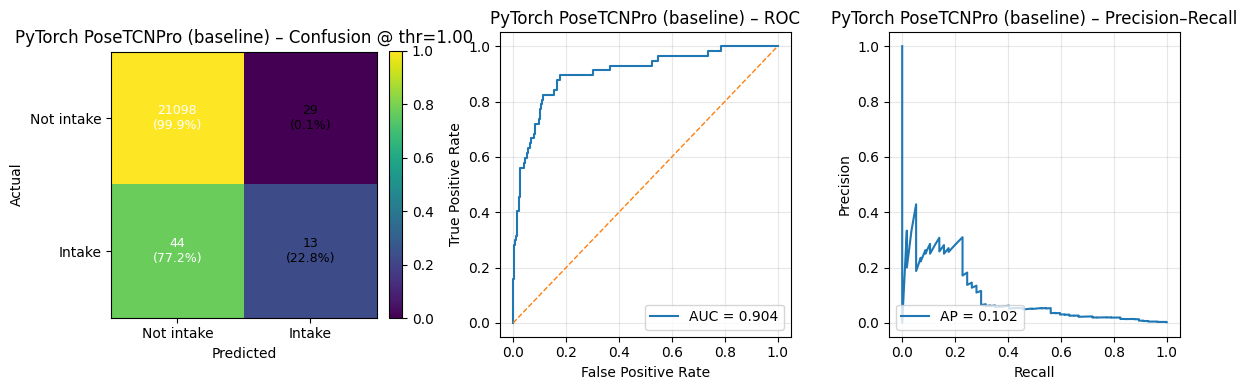

In [ ]:
eval_tcn = evaluate_window_model(
    logits_np=val_logits_np_tcn,
    targets_np=val_y_np,
    label="PyTorch PoseTCNPro (baseline)"
)
best_thr_tcn = eval_tcn["thr"]


## **Keras TCN with Hyperband**

In [ ]:
def make_pose_numpy(windows_df, split, fps=15.0):
    df_split = windows_df[windows_df["split"] == split].reset_index(drop=True)
    ds = PoseWindowDataset(df_split, fps=fps)

    X_list, y_list = [], []
    for i in tqdm(range(len(ds)), desc=f"Building {split} pose numpy"):
        x, y = ds[i]             # x: (T, F); y: scalar
        X_list.append(x.numpy())
        y_list.append(int(y.item()))

    X = np.stack(X_list, axis=0).astype("float32")   # (N, T, F)
    y = np.array(y_list, dtype="int32")              # (N,)
    return X, y

X_train, y_train = make_pose_numpy(windows_df, "train", fps=15.0)
X_val,   y_val   = make_pose_numpy(windows_df, "val",   fps=15.0)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)


Building train pose numpy:   0%|          | 0/62568 [00:00<?, ?it/s]

Building val pose numpy:   0%|          | 0/21184 [00:00<?, ?it/s]

Train: (62568, 30, 19) (62568,)
Val:   (21184, 30, 19) (21184,)


In [ ]:
pos_rate = (y_train == 1).mean()
neg_rate = 1.0 - pos_rate
class_weight = {
    0: 1.0,
    1: float(neg_rate / max(pos_rate, 1e-6)),
}
print("class_weight:", class_weight)


class_weight: {0: 1.0, 1: 147.2654028436019}


In [ ]:
T, F = X_train.shape[1], X_train.shape[2]

def build_tcn_model(hp: kt.HyperParameters):
    inputs = tf.keras.Input(shape=(T, F))
    x = inputs

    # Temporal blocks
    num_blocks = hp.Int("num_blocks", min_value=2, max_value=4, step=1)
    for i in range(num_blocks):
        filters      = hp.Int(f"filters_{i}", min_value=32, max_value=160, step=32)
        kernel_size  = hp.Choice("kernel_size", values=[3, 5, 7])
        dropout_rate = hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)
        dilation     = 2 ** i

        x = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            dilation_rate=dilation,
            use_bias=False,
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Global pooling over time
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Dense head
    dense_units   = hp.Int("dense_units", min_value=32, max_value=160, step=32)
    dense_dropout = hp.Float("dense_dropout", min_value=0.0, max_value=0.5, step=0.1)
    x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
    x = tf.keras.layers.Dropout(dense_dropout)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model   = tf.keras.Model(inputs, outputs)

    lr = hp.Float("lr", min_value=1e-4, max_value=5e-3, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.AUC(curve="PR", name="prc"),
        ],
    )
    return model


### **Keras TCN - Hyperband Search**

In [ ]:
tuner = kt.Hyperband(
    build_tcn_model,
    objective=kt.Objective("val_prc", direction="max"),
    max_epochs=20,
    factor=3,
    directory="keras_tcn_tuning",
    project_name="bitepulse_tcn",
    overwrite=True,
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_prc",
    patience=4,
    mode="max",
    restore_best_weights=True,
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stop],
)


Trial 30 Complete [00h 01m 13s]
val_prc: 0.0968976616859436

Best val_prc So Far: 0.12982948124408722
Total elapsed time: 00h 31m 41s


In [ ]:
best_hp     = tuner.get_best_hyperparameters(1)[0]
best_model  = tuner.get_best_models(1)[0]

print("Best hyperparameters:")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,
    verbose=1,
)


Best hyperparameters:
num_blocks: 2
filters_0: 64
kernel_size: 7
dropout: 0.1
filters_1: 128
dense_units: 128
dense_dropout: 0.30000000000000004
lr: 0.0005320715464796309
filters_2: 64
filters_3: 96
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Epoch 1/10
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - auc: 0.9789 - loss: 0.2990 - prc: 0.3860 - precision: 0.1107 - recall: 0.9175 - val_auc: 0.8877 - val_loss: 0.2365 - val_prc: 0.0863 - val_precision: 0.0168 - val_recall: 0.6491
Epoch 2/10
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.9887 - loss: 0.2485 - prc: 0.4241 - precision: 0.0951 - recall: 0.9609 - val_auc: 0.9018 - val_loss: 0.2329 - val_prc: 0.0667 - val_precision: 0.0190 - val_recall: 0.7368
Epoch 3/10
1956/1956 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.9893 - loss: 0.2333 - prc: 0.4711 - precision: 0.1119 - recall: 0.9771 - val_auc: 0.8837 - val_loss: 0.2038 - val_prc: 0.0834 - val_precision: 0.0225 - val_recall: 0.7193
Epoch

### **Keras TCN - Hyperband Performance Evaluation**

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step

=== Keras TCN (Hyperband best): Validation metrics @ best F1 threshold ===
      threshold(F1*): 0.996
            accuracy: 0.997
           precision: 0.300
              recall: 0.211
                  f1: 0.247
         specificity: 0.999
        balanced_acc: 0.605
                 mcc: 0.250
     roc_auc_overall: 0.924
      pr_auc_overall: 0.134

Confusion Matrix (rows=actual, cols=pred):
[[21099    28]
 [   45    12]]

Classification report:
               precision    recall  f1-score   support

           0      0.998     0.999     0.998     21127
           1      0.300     0.211     0.247        57

    accuracy                          0.997     21184
   macro avg      0.649     0.605     0.623     21184
weighted avg      0.996     0.997     0.996     21184



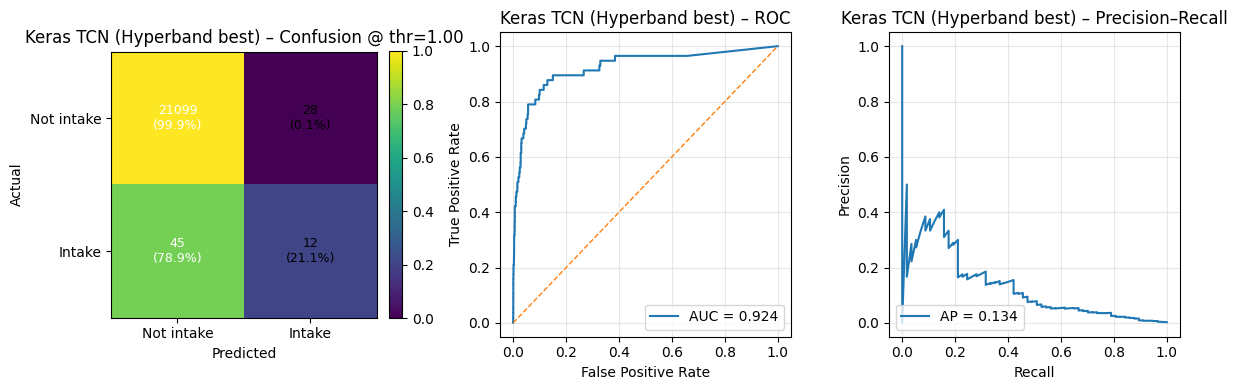

In [ ]:
# Keras gives probabilities; convert to logits for fair comparison
val_probs_keras = best_model.predict(X_val, batch_size=256).reshape(-1)
eps = 1e-7
val_probs_keras = np.clip(val_probs_keras, eps, 1 - eps)
val_logits_np_keras = np.log(val_probs_keras / (1 - val_probs_keras))

# Use same y_val as labels
eval_keras = evaluate_window_model(
    logits_np=val_logits_np_keras,
    targets_np=y_val,
    label="Keras TCN (Hyperband best)"
)
best_thr_keras = eval_keras["thr"]
